In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pandas as pd
import numpy as np

import tensorflow as tf

import skimage
from skimage import color

import skimage.feature

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.draw import line

from scipy.ndimage import filters, morphology

import cv2

# Text Localization (without machine learning)

## Objective

This is an image from my Math homework. The objective is to parse it into math expressions.

How do we get there?

Let's break down the problem:
* Preprocessing the image
* Segmentation (splitting the image into letters/words)
* Recognizing symbols
* Parsing the expressions

Here we will try to use standard preprocessing techniques to split the image into lines.

In [430]:
def show_image(img):
    plt.figure(figsize = (8, 8))
    imshow(img)

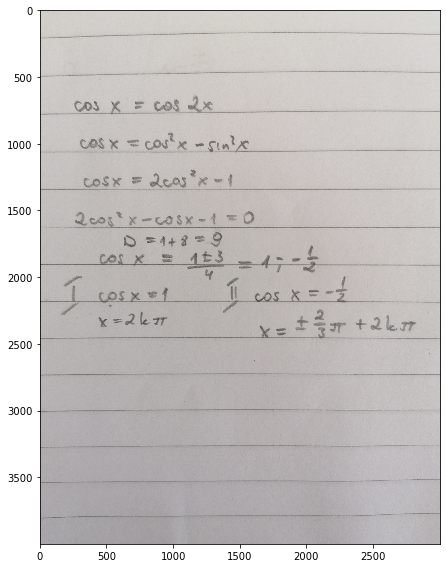

In [431]:
image = imread("math.jpg")
show_image(image)

Let's crop it for the sake of simplicity. In general this should not be hardcoded:

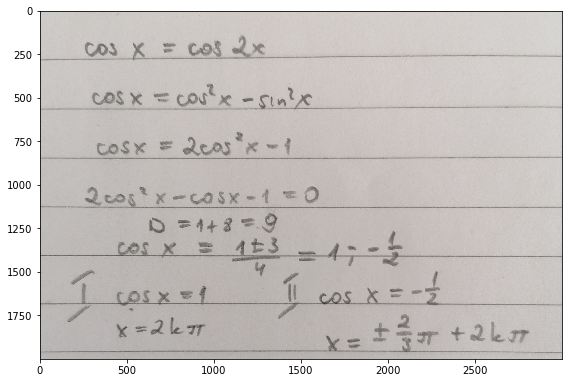

In [432]:
image_cropped = image[500:2500, :]
show_image(image_cropped)

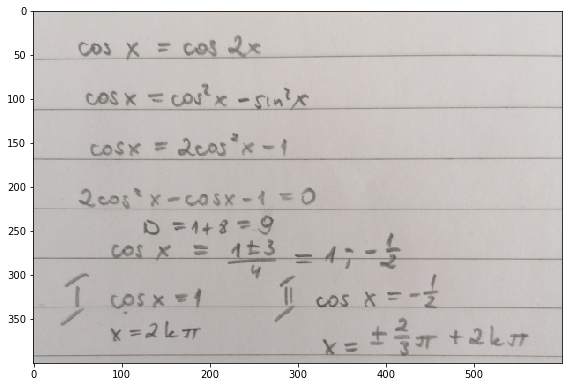

In [492]:
image_resized = cv2.resize(image_cropped, None, fx = 0.2, fy = 0.2, interpolation=cv2.INTER_AREA)
show_image(image_resized)

In [493]:
def image_to_grayscale(img):
    r = img[:, :, 0] 
    g = img[:, :, 1]
    b = img[:, :, 2]
    return (0.2125 * r + 0.7154 * g + 0.0721 * b).astype(np.uint8)

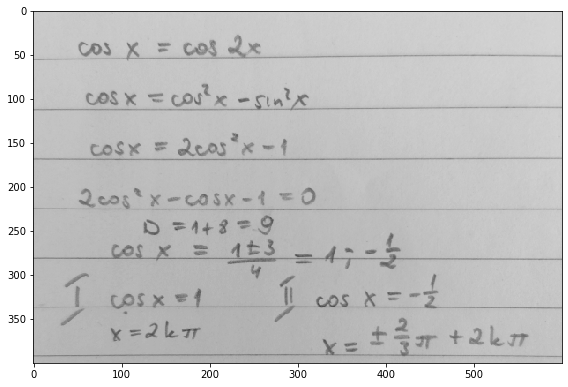

In [518]:
image_grayscale = image_to_grayscale(image_resized)
show_image(image_grayscale)

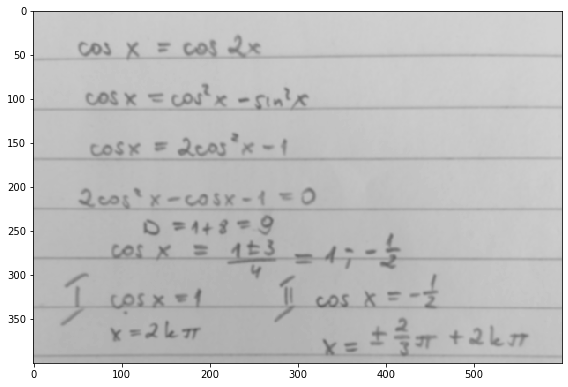

In [534]:
image_blurred = cv2.GaussianBlur(image_grayscale, (5, 5), 0)
show_image(image_blurred)

Adaptive thresholding should be prefered because it takes into account the local area. A global value as a threshold might not be good in all cases, e.g. if an image has different lighting conditions in different areas.

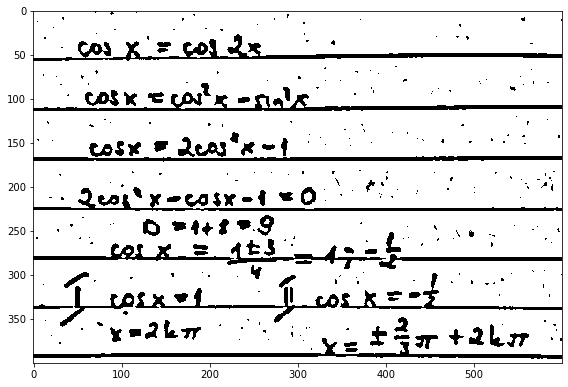

In [535]:
image_thresh = cv2.adaptiveThreshold(image_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
show_image(image_thresh)

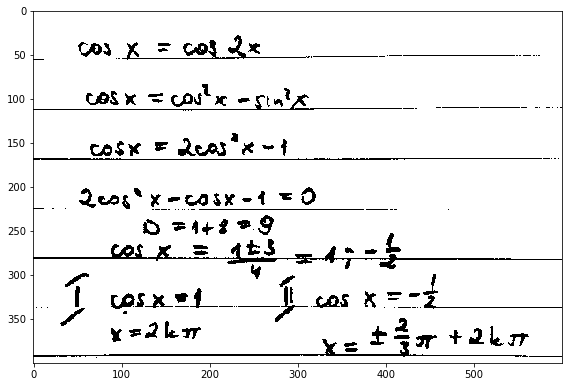

In [536]:
image_thresh_otsu = cv2.threshold(image_grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
show_image(image_thresh_otsu)

Here we combine what we've done so far into one function.

In [703]:
def image_threshold(img, bimodal):
    """
    "img" - a grayscale image with uint8 values from 0 to 255
    """
    if bimodal:
        img_thresh_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        return img_thresh_otsu
    else:
        img_blurred = cv2.GaussianBlur(img, (5, 5), 0).astype(np.uint8)
        img_thresh = cv2.adaptiveThreshold(img_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
        return img_thresh

In [687]:
def preprocess_image(img):
    img = image_to_grayscale(img)
    img = image_threshold(img, bimodal = True)
    return img

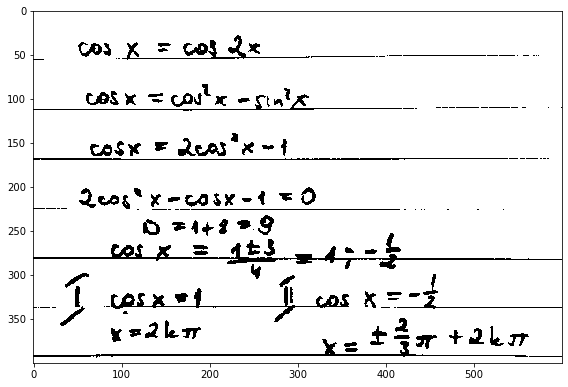

In [688]:
image = preprocess_image(resize(imread("math.jpg")[500:2500, :, :], (400, 600), preserve_range = True))
show_image(image)

We would like to remove those horizontal lines (the ruled paper). 

Maybe we can do that with the fourier transform?

In [541]:
imfft = np.fft.fft2(image)

In [542]:
mags = np.abs(np.fft.fftshift(imfft))
angles = np.angle(np.fft.fftshift(imfft))
visual = np.log(mags)
visual2 = (visual - visual.min()) / (visual.max() - visual.min()) * 255

The bright line in the middle represents those lines:

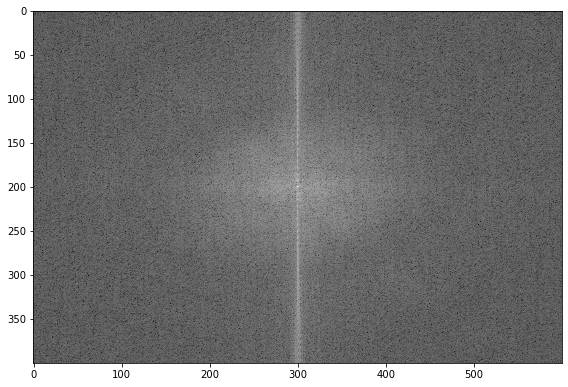

In [543]:
plt.figure(figsize = (8, 8))
imshow(visual2.astype(np.uint8))

That vertical white line tells us something...

In [583]:
# These depend on the image resolution..
LINE_WIDTH = 5
ADAPTIVE_THRESHOLD_BLOCK_SIZE = 53

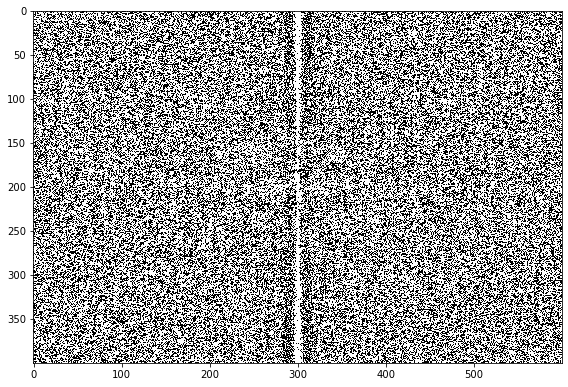

In [584]:
thresh = cv2.adaptiveThreshold(visual2.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, ADAPTIVE_THRESHOLD_BLOCK_SIZE, 1)
show_image(thresh)

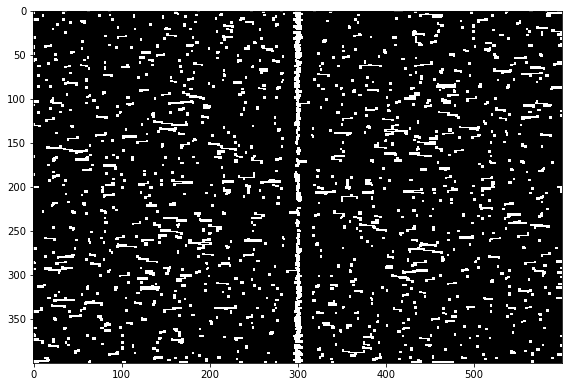

In [585]:
kernel = np.ones((3,3), np.uint8)
morph = cv2.morphologyEx(thresh.astype(float), cv2.MORPH_OPEN, kernel)
kernel = np.ones((1,9), np.uint8)
morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel).astype(np.uint8)

show_image(morph)

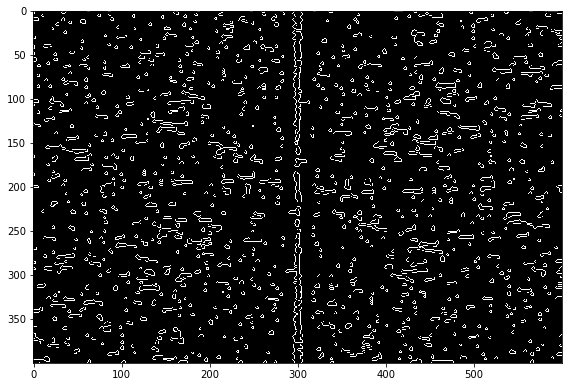

In [591]:
edges = cv2.Canny(morph, 100, 200)
show_image(edges)

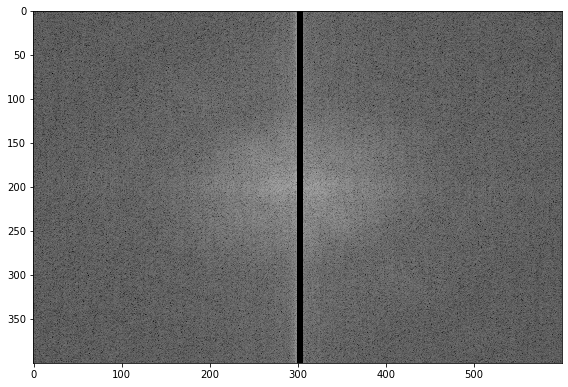

In [592]:
masked_visual2 = visual2.copy()
lines = cv2.HoughLines(edges, 1, np.pi / 180, 50)

# Draw line on the image
for rho, theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(masked_visual2, (x1, y1), (x2, y2), 0, LINE_WIDTH)

show_image(masked_visual2.astype(np.uint8))

In [593]:
def get_mask_for_ftt(fft):
    mags = np.abs(np.fft.fftshift(fft))
    angles = np.angle(np.fft.fftshift(fft))
    visual = np.log(mags)
    
    thresh = cv2.adaptiveThreshold(visual2.astype(np.uint8), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, ADAPTIVE_THRESHOLD_BLOCK_SIZE, 1)
    
    kernel = np.ones((3,3), np.uint8)
    morph = cv2.morphologyEx(thresh.astype(float), cv2.MORPH_OPEN, kernel)
    kernel = np.ones((1,9), np.uint8)
    morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel).astype(np.uint8)

    edges = cv2.Canny(morph, 100, 200)

    mask = np.zeros(visual.shape)
    
    # Draw just the first line
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 50)
    for rho, theta in lines[0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(mask, (x1, y1), (x2, y2), 255, LINE_WIDTH)
    return mask.astype(np.uint8)

So far we have this:

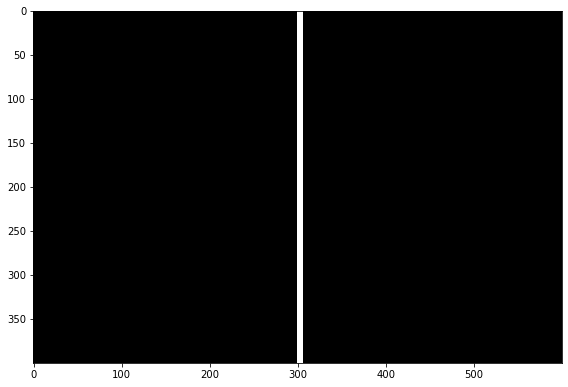

In [594]:
image = preprocess_image(resize(imread("math.jpg")[500:2500, :, :], (400, 600), preserve_range = True))
fft = np.fft.fft2(image)
mask = get_mask_for_ftt(fft)
show_image(mask)

In [595]:
mask_indices = np.where(mask == 255, True, False)
# mask_indices[:500, :] = False
# mask_indices[700:1250, :] = False
# mask_indices[1500:, :] = False
# mask_indices[450:1550, :] = False

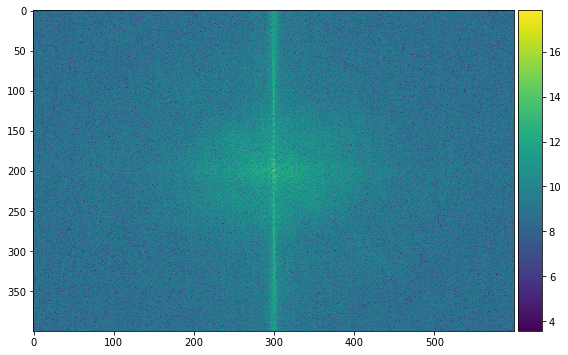

In [596]:
mags = np.abs(np.fft.fftshift(fft))
angles = np.angle(np.fft.fftshift(fft))
visual = np.log(mags)

plt.figure(figsize = (8, 8))
imshow(visual)

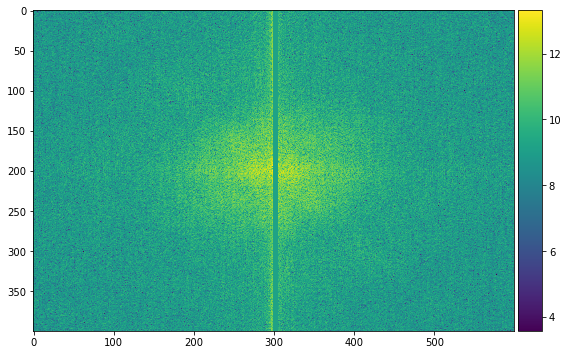

In [599]:
visual_masked = visual.copy()
visual_masked[mask_indices] = np.mean(visual)

plt.figure(figsize = (8, 8))
imshow(visual_masked)

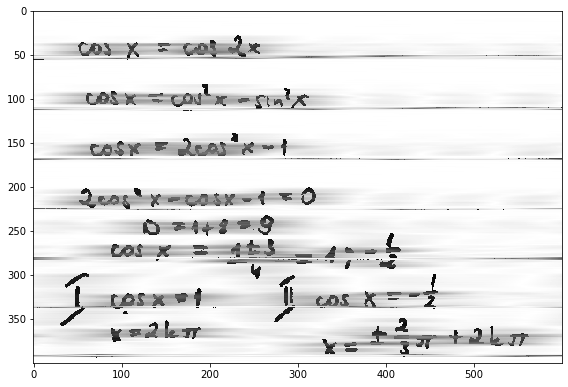

In [600]:
newmagsshift = np.exp(visual_masked)
newffts = newmagsshift * np.exp(1j * angles)
newfft = np.fft.ifftshift(newffts)
imrev = np.fft.ifft2(newfft)
new_image = 255 - np.abs(imrev).astype(np.uint8)
show_image(new_image)

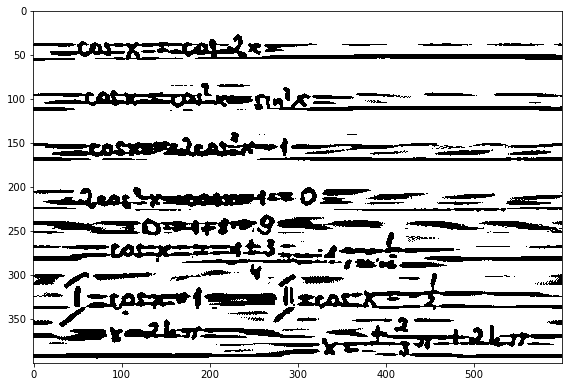

In [604]:
new_image_thresh = image_threshold(new_image, bimodal = False)
show_image(new_image_thresh)

In [610]:
def find_groups_of_zeros(data, thresh = 1, group_thresh = 2):
    """
    Finds the centers of groups of repeated "zeros" in an array.
    A number below 'thresh' is considered a zero.
    'group_thresh' specifies the minimum size of a group. Default is 2 - i.e. groups must be atleast size 2. 
    """
    groups = []
    last_start = 0
    last_end = 0
    in_group = 0

    for i in range(1, len(data) - 1):
        if not in_group:
            if data[i] < thresh and data[i - 1] >= thresh:
                last_start = i
                in_group = 1
        else:  # A group continued.
            if data[i] < thresh:
                last_end = i
            elif last_end - last_start >= group_thresh:  # We have a group 
                mid_point = (last_end - last_start) + last_start
                groups.append(((last_end - last_start) // 2) + last_start)
                last_start, last_end, in_group = (0, 0, 0)
            else:  # Group was too small
                last_start, last_end, in_group = (0, 0, 0)
    return groups

In [627]:
def plot_horizontal_histogram(img, thresh, group_thresh):
    img_binary = np.where(img == 255, 1, 0)
    img_row_sum = np.sum(1 - img_binary, axis = 1)
    
    plt.figure(figsize = (10, 10))
    plt.barh(np.arange(0, img.shape[0]), img_row_sum)

    plt.hlines(find_groups_of_zeros(img_row_sum, thresh, group_thresh), xmin = 0, xmax = 600, color = "yellow")
    
    plt.gca().invert_yaxis()
    plt.show()

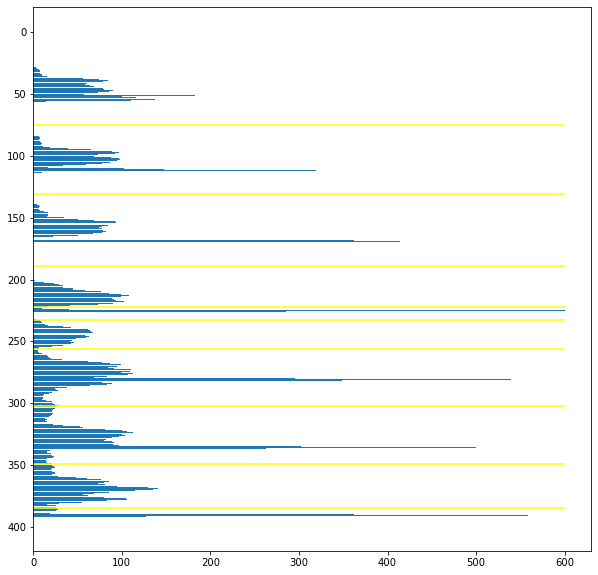

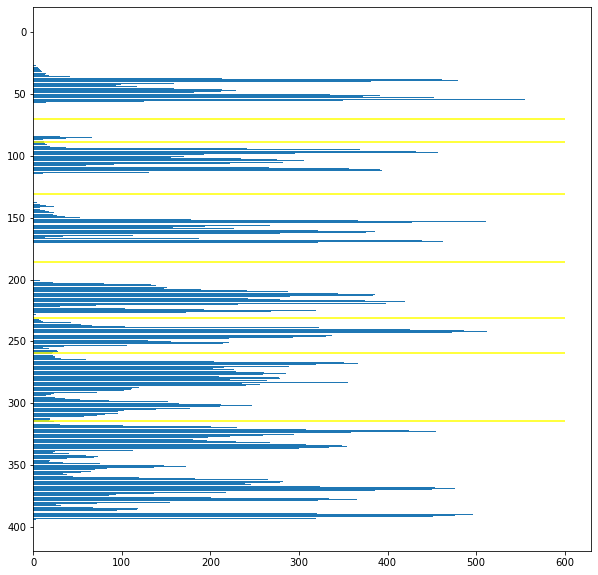

In [630]:
plot_horizontal_histogram(image, 50, 3)
plot_horizontal_histogram(new_image_thresh, 50, 5)

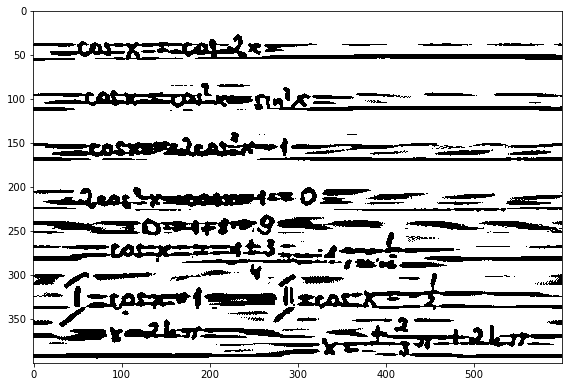

In [631]:
show_image(new_image_thresh)

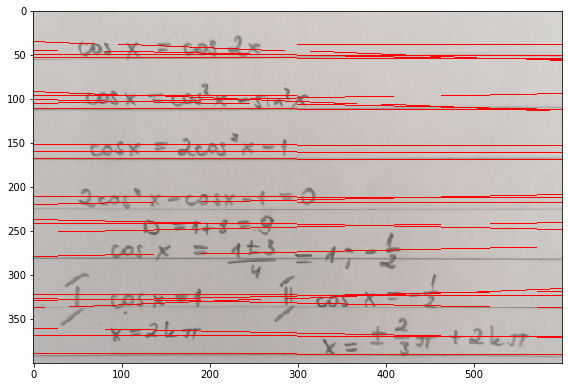

In [671]:
new_image_thresh_lines = resize(imread("math.jpg")[500:2500, :, :], (400, 600), preserve_range = True).astype(np.uint8)
lines = cv2.HoughLines(255 - new_image_thresh, 1, np.pi / 180, 370)

# Draw line on the image
for l in lines:
    for rho, theta in l:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        cv2.line(new_image_thresh_lines, (x1, y1), (x2, y2), (255, 0, 0), 1)
show_image(new_image_thresh_lines)

In [716]:
def get_lines_from_image(img):
    """img is RGB with range 0 to 255"""
    img = img.astype(np.uint8)
    img_processed = preprocess_image(img)
    
    fft = np.fft.fft2(img_processed)
    mask = get_mask_for_ftt(fft)
    
    mask_indices = np.where(mask == 255, True, False)
    mags = np.abs(np.fft.fftshift(fft))
    angles = np.angle(np.fft.fftshift(fft))
    visual = np.log(mags)

    visual_masked = visual.copy()
    visual_masked[mask_indices] = np.mean(visual)

    newmagsshift = np.exp(visual_masked)
    newffts = newmagsshift * np.exp(1j * angles)
    newfft = np.fft.ifftshift(newffts)
    imrev = np.fft.ifft2(newfft)
    new_img = 255 - np.abs(imrev).astype(np.uint8)
    new_img = image_threshold(new_img, bimodal = False)
    
    img_result = img.copy()
    new_img_hough_lines = cv2.HoughLines(255 - new_img, 1, np.pi / 180, 370)

    # Draw line on the image
    for l in new_img_hough_lines:
        for rho, theta in l:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            cv2.line(img_result, (x1, y1), (x2, y2), (255, 0, 0), 1)    
    return img_result

In [701]:
math_image = resize(imread("math.jpg")[500:2500, :, :], (400, 600), preserve_range = True)

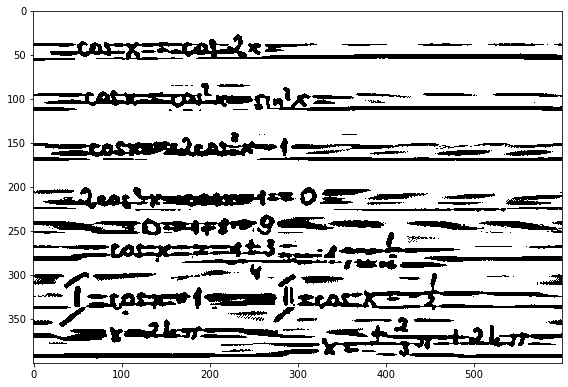

In [717]:
image_lines = get_lines_from_image(math_image)
show_image(image_lines)

Unfortunetaly this doesn't seem to work in the general case of any image.
It's just too much options to tweak. A neural network is much better suited for the task of images.

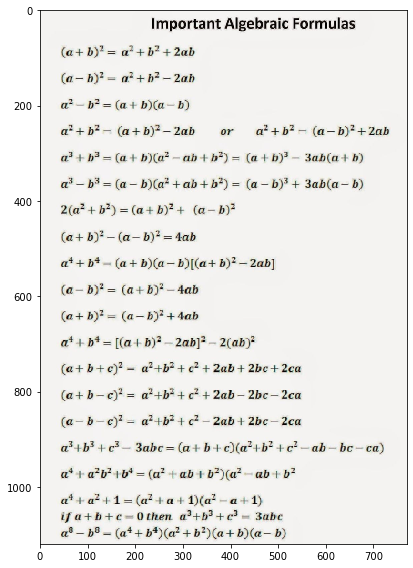

In [714]:
math_image_2 = imread("math_2.jpg")
math_image_2 = cv2.resize(math_image_2 , None, fx = 0.7, fy = 0.7, interpolation=cv2.INTER_AREA)
show_image(math_image_2)

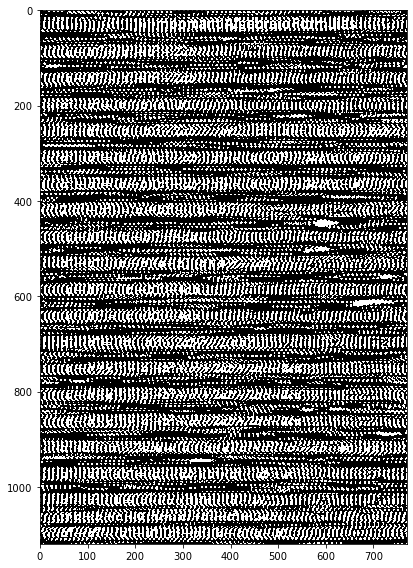

In [718]:
image_lines_2 = get_lines_from_image(math_image_2)
show_image(image_lines_2)

## References

- Line and word level segmentation: https://towardsdatascience.com/segmentation-in-ocr-10de176cf373
- Hough lines: https://stackoverflow.com/questions/61470949/opencv-detecting-brightest-line-on-fft
